/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.0227 - val_loss: 0.0294
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0257
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0218
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055 - val_loss: 0.0168
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0145
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0040 - val_loss: 0.0148
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0031 - val_loss: 0.0114
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0026 - val_loss: 0.0071
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0025 - val_loss: 0.0069
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0037 - val_loss: 0.0070
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - val_loss: 0.0071
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 

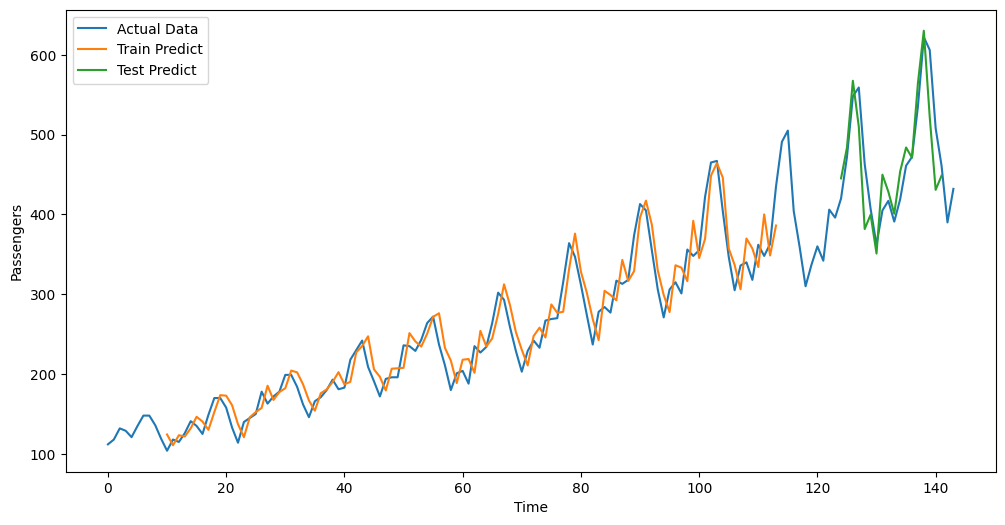

Train MAE: 20.30
Test MAE: 34.41
Train MSE: 566.35
Test MSE: 1534.99
Train RMSE: 23.80
Test RMSE: 39.18


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
import pickle

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, usecols=[1])
data = data.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test))

# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Data')
plt.plot(range(time_step, len(train_predict) + time_step), train_predict, label='Train Predict')
plt.plot(range(len(train_predict) + (time_step * 2), len(train_predict) + (time_step * 2) + len(test_predict)), test_predict, label='Test Predict')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Saving the model
model.save('air_passenger_gru_model.h5')

from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE, MSE and RMSE 
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
